In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pylab as plt
import seaborn as sns

df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header=None, names=['user', 'label', 'timestamp', 'x', 'y', 'z'], comment=';')
df = df.sort_values('timestamp')


In [2]:
print 'labels:', df.label.unique()

labels: ['Walking' 'Jogging' 'Upstairs' 'Downstairs' 'Standing' 'Sitting']


In [21]:
# The Label to explore, one of 'Walking' 'Jogging' 'Upstairs' 'Downstairs' 'Standing' 'Sitting'
LABEL = 'Standing'

# The maximum number of plots to show
MAX_PLOTS = 2

# The axis to visualize
AXIS = 'x'

# Window length to use for the FFT
WINDOW_LENGTH = 80

# The sampling rate to use
SAMPLING_RATE = 20.0


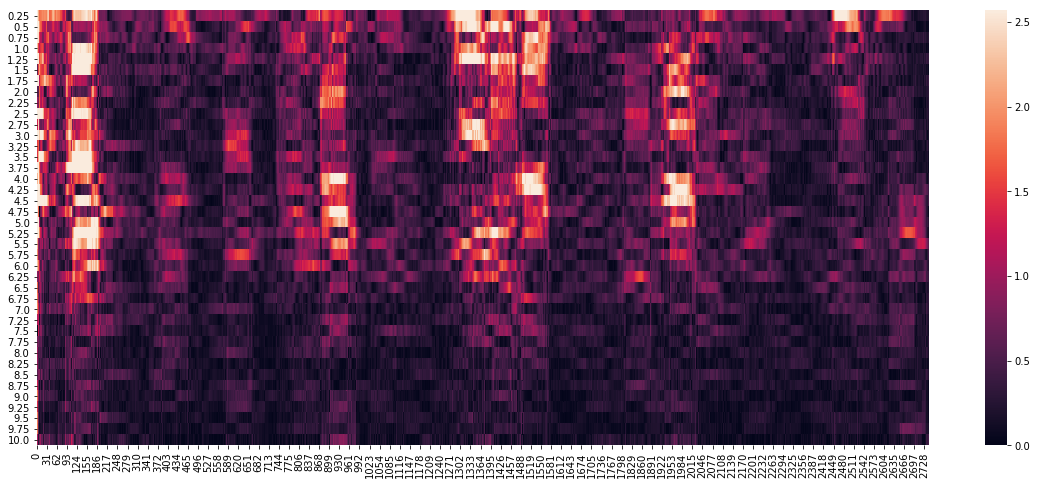

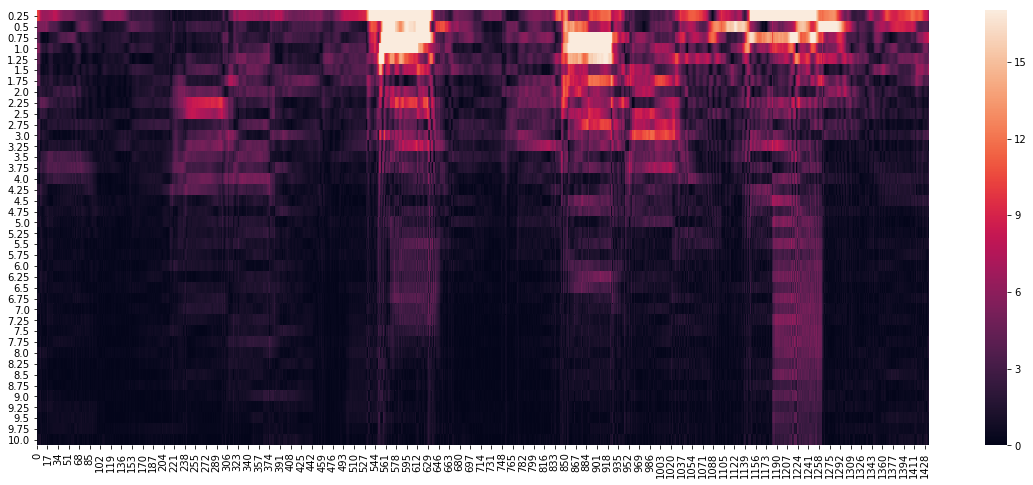

In [22]:
import numpy as np
from utils import sliding_window, split_user_df
from preprocessing import resample_df

# Filter DataFrame with selected label
label_df = df[(df.label == LABEL)].reset_index(drop=True)

# Split the label DataFrame per user
users = label_df.groupby('user')
plt_idx = 0
for user, user_df in users:
    
    # Split the user DataFrame per recording session
    splits = split_user_df(user_df)
    
    if plt_idx == MAX_PLOTS:
        break

    for split_df in splits:
        
        if plt_idx == MAX_PLOTS:
            break
        
        # Calculate the timestamp index in seconds
        ts =(split_df.timestamp - split_df.timestamp.iloc[0]) / 1e9

        if ts.iloc[-1] < 10:
            # Skip sessions that are smaller than 10 seconds
            continue
        
        # Resample the DataFrame to SAMPLING_RATE
        split_df = resample_df(split_df, SAMPLING_RATE)

        # Create sliding windows
        wdws = sliding_window(split_df[AXIS], ws=(WINDOW_LENGTH,), ss=(1,))
        
        # calculate fft of the sliding windows
        ffts = np.abs(np.fft.fft(wdws))

        # Calculate the frequencies that correspond with the resulting FFT window
        freq = np.abs(np.fft.fftfreq(wdws.shape[-1], d=1.0/SAMPLING_RATE)[1:ffts.shape[-1]/2 + 1].round(2))
        
        # remove negative semmatric half
        ffts = ffts[:, 1:ffts.shape[-1]/2 + 1]
 
        vmin= 0
        vmax=np.percentile(ffts, 99)
        
        fig, ax = plt.subplots(figsize=(20,8)) 

        # plot heatmap off fft windows
        sns.heatmap(ffts.T, vmin=vmin, vmax=vmax, ax=ax, yticklabels=freq)
        
        
        # Show the plot
        plt.show()
        plt_idx += 1
 